In [19]:
#=====================================================
# Calculate the <<Real IPD and DataSet_A>>
# Initialization Parameter: Pars_mu
#=====================================================
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import sys,time
from numba import jit
from math import sqrt
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
%matplotlib inline

# Global Quantities:
#===========================================================================
# Crastal Cell Numbers and SIPM Numbers
PositionX_Num = 2
PositionY_Num = 2
PositionZ_Num = 2
PositionNumsXYZ =  np.array([PositionX_Num,PositionY_Num,PositionZ_Num])
Position_Nums = PositionX_Num * PositionY_Num * PositionZ_Num
Channel_Nums = 6*6*2
# The Processing Gamma numbers
ProcessNum = 500000

floor = math.floor
sqrt = math.sqrt
np_sqrt = np.sqrt

In [20]:
# Functions
#===========================================================================

# Calculate Crastal Cell Coordinates: (x_i,y_i.z_i), in mm
#----------------------------------------------
@jit
def Cal_Crastal_Sites(PositionNumsXYZ):
    CellNums = PositionNumsXYZ[0]*PositionNumsXYZ[1]*PositionNumsXYZ[2] #(x,y,z)
    Crastal_SizeXYZ = np.array([20,20,20]) # mm  #(x,y,z)

    index = np.arange(CellNums) #Numpy: shape[3] -> shape[2] ->shape[1] -> shape[0]
    index.shape = (PositionNumsXYZ[2],PositionNumsXYZ[1],PositionNumsXYZ[0]) # (NumZ,NumY,NumX) eg (2,6,6)
    X = np.zeros(shape = (CellNums),dtype = float)
    Y = np.zeros(shape = (CellNums),dtype = float)
    Z = np.zeros(shape = (CellNums),dtype = float)
    for i in np.arange(CellNums):
        index_i = np.array(np.where(index == i))
        index_i.shape = (3,)
        #print(index_i)
        X[i] = index_i[2] * (Crastal_SizeXYZ[0] / PositionNumsXYZ[0]) - Crastal_SizeXYZ[0] / 2 + Crastal_SizeXYZ[0] / (2*PositionNumsXYZ[0])
        Y[i] = index_i[1] * (Crastal_SizeXYZ[1] / PositionNumsXYZ[1]) - Crastal_SizeXYZ[1] / 2 + Crastal_SizeXYZ[1] / (2*PositionNumsXYZ[1])
        Z[i] = index_i[0] * (Crastal_SizeXYZ[2] / PositionNumsXYZ[2]) - Crastal_SizeXYZ[2] / 2 + Crastal_SizeXYZ[2] / (2*PositionNumsXYZ[2])
    return X,Y,Z

# Calculate SIPM Coordinates: (x_s,y_s.z_s), in mm
#----------------------------------------------
@jit
def Cal_SIPM_Sites():
    SIPM_gap = 0.29
    SIPM_size = 3.07
    Crastal_size = 20
    Coupling_layer = 0.1
    SIPM_thick = 2
    SIPM_Sites_array_XY = [-2.5*(SIPM_size+SIPM_gap),-1.5*(SIPM_size+SIPM_gap),-0.5*(SIPM_size+SIPM_gap),0.5*(SIPM_size+SIPM_gap),1.5*(SIPM_size+SIPM_gap),2.5*(SIPM_size+SIPM_gap)]
    SIPM_Sites_array_Z = [-(0.5*(Crastal_size + SIPM_thick) + Coupling_layer),0.5*(Crastal_size + SIPM_thick) + Coupling_layer]
    index = np.arange(6*6*2)
    index.shape = (2,6,6) #  (Z,Y,X) X -> Y -> Z 
    X = np.zeros(shape = (6*6*2),dtype = float)
    Y = np.zeros(shape = (6*6*2),dtype = float)
    Z = np.zeros(shape = (6*6*2),dtype = float)
    for s in np.arange(6*6*2):
        index_s = np.array(np.where(index == s))
        index_s.shape = (3,)
        #print(index_s)
        X[s] = SIPM_Sites_array_XY[index_s[2]]
        Y[s] = SIPM_Sites_array_XY[index_s[1]]
        Z[s] = SIPM_Sites_array_Z[index_s[0]]
    return X,Y,Z

# Initializing Parameter mu_is
#----------------------------------------------
@jit
def Pars_Initialization(Coor_Cells,Coor_SIPMs):
    mu_is = np.zeros(shape = (Coor_Cells.shape[1],Coor_SIPMs.shape[1]),dtype = float)
    for i in range(Coor_Cells.shape[1]):
        for s in range(Coor_SIPMs.shape[1]):
            mu_is[i][s] = 1. / ((Coor_Cells[0][i] - Coor_SIPMs[0][s])**2 + (Coor_Cells[1][i] - Coor_SIPMs[1][s])**2 + (Coor_Cells[2][i] - Coor_SIPMs[2][s])**2)
    # Normalization
    Sum_SIPM_i = np.sum(mu_is,axis = 1)
    for i in range(Coor_Cells.shape[1]):
        mu_is[i,:] = mu_is[i,:] / Sum_SIPM_i[i]
    return mu_is

In [21]:
#===== 1 ===== Calculate Crastal & SIPM coordinates  
#===========================================================================
Crastal_X,Crastal_Y,Crastal_Z = Cal_Crastal_Sites(PositionNumsXYZ)
SIPM_X,SIPM_Y,SIPM_Z = Cal_SIPM_Sites()
Coor_Cells = np.array([Crastal_X,Crastal_Y,Crastal_Z])
Coor_SIPMs = np.array([SIPM_X,SIPM_Y,SIPM_Z])
print("==================================================================")
print("---------------------------------1--------------------------------")
print("==================================================================")
print("Calculating Crastal (according to the grid nums) and SIPM cells' centers coordination as:")
print("Coor_Cells[Crastal_X,Crastal_Y,Crastal_Z] and Coor_SIPMs[SIPM_X,SIPM_Y,SIPM_Z]")
print("Crastal coor's shape:",Coor_Cells.shape)
print("SIPM coor's shape:",Coor_SIPMs.shape)
print("Index sorted order: X -> Y -> Z")

---------------------------------1--------------------------------
Calculating Crastal (according to the grid nums) and SIPM cells' centers coordination as:
Coor_Cells[Crastal_X,Crastal_Y,Crastal_Z] and Coor_SIPMs[SIPM_X,SIPM_Y,SIPM_Z]
Crastal coor's shape: (3, 8)
SIPM coor's shape: (3, 72)
Index sorted order: X -> Y -> Z


In [22]:
#===== 2 ===== Read simulated data   
#===========================================================================
#Cut Energy
df = pd.read_csv('data/dataA_Singles.txt',header = None,delimiter=" ")
df.columns = ['x','y','z','Edep']
df_cut = df[df['Edep'] >= 0.510].copy()  #注意索引变了，直接使用索引就会有问题
df_cut = df_cut.reset_index(drop=True)  #Reset index
print('Cut Eep < 0.51 shape:',df_cut.shape)
#print(df_cut.info())
#----------------------------------------------
# Cut an assigned number of events
Gamma_Num = ProcessNum
df_test = df_cut.iloc[0:Gamma_Num].copy()
Light_Yield = 50000 # 1/MeV
Resolution = 0.10  # GAGG crastal 10% @ 0.511MeV
print("==================================================================")
print("---------------------------------2--------------------------------")
print("==================================================================")
print('Data Preparing...........')
print("Simulated Gamma events (> 510 eV):",df_cut.shape[0])
print("Processing Gamma events:",df_test.shape[0])

df_test.iloc[:8]

Cut Eep < 0.51 shape: (524280, 4)
---------------------------------2--------------------------------
Data Preparing...........
Simulated Gamma events (> 510 eV): 524280
Processing Gamma events: 500000


,x,y,z,Edep
0,-7.86084,1.844020,7.28039,0.511
1,2.53285,0.615561,2.95402,0.511
2,3.49118,-7.480860,3.28973,0.511
3,3.04109,-7.029700,2.06908,0.511
4,-4.08897,-3.216470,8.62749,0.511
5,-7.74779,2.970800,-5.89749,0.511
6,-8.32235,3.183920,-2.58078,0.511
7,6.61927,1.831820,-3.75156,0.511


In [23]:
#===== 3 ===== Calculate photon numbers
#===========================================================================
@jit
def Cal_Photons(row):
    sqrt = math.sqrt
    sigma = Resolution*sqrt(0.511)*sqrt(row['Edep'])
    E_rec = np.random.normal(row['Edep'],sigma,1)
    PhotonNum = np.abs(np.round(Light_Yield * E_rec))
    return PhotonNum

print("==================================================================")
print("---------------------------------3--------------------------------")
print("==================================================================")
print('Calculating photon numbers produced by Gamma events...............')
begin_time2_1 = time.time()
df_test['PhotonNums'] = df_test.apply(Cal_Photons,axis = 1)   ### 1.8s/10000 events
df_test['PhotonNums'] = df_test['PhotonNums'].astype(float)
begin_time2_2 = time.time()
print("Running Time:",begin_time2_2 - begin_time2_1,"s")
print('Test PhotonNums < 0:',df_test[df_test['PhotonNums'] <= 0].shape)
print('Test Edep < 0:',df_test[df_test['Edep'] <= 0].shape)

df_test.iloc[:8]

---------------------------------3--------------------------------
Calculating photon numbers produced by Gamma events...............
Running Time: 248.68276262283325 s
Test PhotonNums < 0: (0, 5)
Test Edep < 0: (0, 5)


,x,y,z,Edep,PhotonNums
0,-7.86084,1.844020,7.28039,0.511,22909.0
1,2.53285,0.615561,2.95402,0.511,25934.0
2,3.49118,-7.480860,3.28973,0.511,26801.0
3,3.04109,-7.029700,2.06908,0.511,21247.0
4,-4.08897,-3.216470,8.62749,0.511,29193.0
5,-7.74779,2.970800,-5.89749,0.511,29164.0
6,-8.32235,3.183920,-2.58078,0.511,24369.0
7,6.61927,1.831820,-3.75156,0.511,23214.0


In [6]:
#===== 4 ===== Griding - Method 1
#===========================================================================
# Calculate the grid ID according to the Crastal grid nums
@jit
def Cal_Real_Grid_ID_1(row):
    Coor_Cells_tem = Coor_Cells.copy()
    for i in np.arange(Coor_Cells.shape[1]):  # Coor_Cells.shape = 3,8
        Coor_Cells_tem[:,i] = Coor_Cells[:,i] - np.array([row['x'],row['y'],row['z']])
    GridID = np.sum(Coor_Cells_tem**2,axis = 0).argmin()
    return GridID


print("==================================================================")
print("---------------------------------4--------------------------------")
print("==================================================================")
print('Griding by Method 1...............')
t1 = time.time()
df_test['GridID'] = df_test.apply(Cal_Real_Grid_ID_1,axis = 1)   ### 56.8s/10000events
t2 = time.time()
df_test['GridID'] = df_test['GridID'].astype(int)
print('Time Exhausted:',t2 - t1,'s')

df_test.iloc[:5]  

---------------------------------4--------------------------------
Griding by Method 1...............
Time Exhausted: 44.59698033332825 s


,x,y,z,Edep,PhotonNums,GridID
0,-7.86084,1.844020,7.28039,0.511,26381.0,6
1,2.53285,0.615561,2.95402,0.511,25368.0,7
2,3.49118,-7.480860,3.28973,0.511,21908.0,5
3,3.04109,-7.029700,2.06908,0.511,27403.0,5
4,-4.08897,-3.216470,8.62749,0.511,26406.0,4


In [24]:
#===== 4 ===== Griding - Method 2  FAST******** [USE]
#===========================================================================
# Should exclude (x,y,z) == 10 points
@jit
def Cal_Real_Grid_ID_2(row):
    L = 20 #mm
    N_x = 2
    N_y = 2
    N_z = 2
    index_x = floor((N_x * row['x'] / L) + N_x / 2)  # i = x * N/L + N/2, N_x = PositionNumsXYZ[0], L = 20mm
    index_y = floor((N_y * row['y'] / L) + N_y / 2)  #N_y = PositionNumsXYZ[1]
    index_z = floor((N_z * row['z'] / L) + N_z / 2)  #N_z = PositionNumsXYZ[2]
    GridID = index_x + index_y * N_y + index_z * N_z * N_y
    return GridID

# Executing 
print("==================================================================")
print("---------------------------------4--------------------------------")
print("==================================================================")
print('Check x,y,z != 10, if ==10:',df_test[df_test['x'] ==10].shape,df_test[df_test['y'] ==10].shape,df_test[df_test['z'] ==10].shape)
print('Griding by Method 2...............')
t1 = time.time()
df_test['GridID'] = df_test.apply(Cal_Real_Grid_ID_2,axis = 1)   ### 1.3s/10000events
t2 = time.time()
df_test['GridID'] = df_test['GridID'].astype(int)
print('Time Exhausted:',t2 - t1,'s')

df_test.iloc[:5]  

---------------------------------4--------------------------------
Check x,y,z != 10, if ==10: (0, 5) (0, 5) (0, 5)
Griding by Method 2...............
Time Exhausted: 96.67738771438599 s


,x,y,z,Edep,PhotonNums,GridID
0,-7.86084,1.844020,7.28039,0.511,22909.0,6
1,2.53285,0.615561,2.95402,0.511,25934.0,7
2,3.49118,-7.480860,3.28973,0.511,26801.0,5
3,3.04109,-7.029700,2.06908,0.511,21247.0,5
4,-4.08897,-3.216470,8.62749,0.511,29193.0,4


In [25]:
#===== 5 ===== Calculate IPD Method 1    [USE]
#===========================================================================
# Count grid events and calculate P_i as Distri_P
print('Counting the real IPD by Method 1..............')
t5_1_1 = time.time()
df_grouped = df_test.groupby('GridID',as_index = False).count() #count
GridID_index = np.array(df_grouped['GridID'])
GridID_Distri_P = np.array(df_grouped['x'] / Gamma_Num)
Real_Distri_P = np.zeros(shape = (Position_Nums),dtype = float)
Real_Distri_P[GridID_index] = GridID_Distri_P # p_i
t5_1_2 = time.time()

#----------------------------------------------
print("==================================================================")
print("---------------------------------5--------------------------------")
print("==================================================================")
print("Real_Distri_P.sum:",Real_Distri_P.sum(axis = 0))
print("IPD cell counts / Cells =",GridID_index.shape[0],"/",Position_Nums)
print("Running Time:",t5_1_2 - t5_1_1,"s")

GridID_Distri_P

Counting the real IPD by Method 1..............
---------------------------------5--------------------------------
Real_Distri_P.sum: 1.0
IPD cell counts / Cells = 8 / 8
Running Time: 0.40491819381713867 s


array([0.093836, 0.094398, 0.094256, 0.094618, 0.155474, 0.156324,
       0.155588, 0.155506])

In [26]:
#===== 6 ===== Calculate signal dataset A: a_ns
#===========================================================================
# ==6_1== Importing Data
#----------------------------------------------
print("==================================================================")
print("---------------------------------6--------------------------------")
print("==================================================================")
print('Loading Interpotating Kis.................')

# Interpolating kis
t6_1 = time.time()
data_Whole_Detector_kis_Interp = np.load('data/Results_Photon/data_Whole_Detector_kis_Interp.npy') # 159s = 3mins
t6_2 = time.time()
print('Loading Time:',t6_2 - t6_1,'s','shape:',data_Whole_Detector_kis_Interp.shape)
data_Whole_Detector_kis_Interp.shape = (200,200,200,6*6*2) # Reshape


---------------------------------6--------------------------------
Loading Interpotating Kis.................
Loading Time: 257.66854190826416 s shape: (8000000, 72)


In [76]:
data_Whole_Detector_kis_Interp.shape 

(200, 200, 200, 72)

In [27]:
# ==6_2== Calculating DataSetA Method 2     FAST*******
#--------------------------------------
@jit
def Cal_DataSetA_2(row):
    #t_1 =time.time()
    # - Declaring
    SIPM_Signal = np.zeros(shape = 6*6*2,dtype = float) 
    # - Griding
    L = 20 #mm                                            
    N_x = 200
    N_y = 200
    N_z = 200
    index_x = floor((N_x * row['x'] / L) + N_x / 2)  # i = x * N/L + N/2,  L = 20mm
    index_y = floor((N_y * row['y'] / L) + N_y / 2)  
    index_z = floor((N_z * row['z'] / L) + N_z / 2)  
    # - Acquiring Kis
    Kis_tem = data_Whole_Detector_kis_Interp[index_z,index_y,index_x,:] 
    # - Calculating Ais
    Martrix_mu = Kis_tem * row['PhotonNums'] 
    Martrix_sigma = np_sqrt(Kis_tem * (1 - Kis_tem) * row['PhotonNums'])
    for s in np.arange(SIPM_Signal.shape[0]):
#         mu = Kis_tem[s] * row['PhotonNums'] 
#         sigma = sqrt(Kis_tem[s] * row['PhotonNums'] * (1 - Kis_tem[s]))
        SIPM_Signal[s] = np_normal(Martrix_mu[s],Martrix_sigma[s],1)
#         SIPM_Signal[s] = np.random.normal(mu,sigma,1)
    SIPM_Signal = SIPM_Signal / SIPM_Signal.sum(axis = 0) # Normalizing
    #t_2 =time.time()
    #print(index_x,index_y,index_z,Kis_tem.shape,Martrix_mu.shape,Martrix_sigma.shape)
    #print(t_2 - t_1,'s')
    return SIPM_Signal

print('Calculating the real signal dataSet A_ns by Method 2...............')
np_normal = np.random.normal
t6_2_1 =time.time()
df_test['SIPM_Signal'] = df_test.apply(Cal_DataSetA_2,axis = 1)   # 16s /10000      203s / 100000
t6_2_2 =time.time()
print('Time Exhausted:',t6_2_2 - t6_2_1,'s')


Calculating the real signal dataSet A_ns by Method 2...............
Time Exhausted: 258.27375650405884 s


In [28]:
#Get DataSetA and GridID
# Declaring
DataSet_A = np.zeros(shape = (Gamma_Num,6*6*2),dtype = float)
DataSet_A_GridID = np.zeros(shape = (Gamma_Num),dtype = float)
for n in range(df_test.shape[0]):
    DataSet_A[n,:] = df_test['SIPM_Signal'][n]
    DataSet_A_GridID[n] = df_test['GridID'][n]

In [29]:
#====== 7 ===== Initializing Parameter mu_is
#===========================================================================
t7_1 =time.time()
Pars_mu = Pars_Initialization(Coor_Cells,Coor_SIPMs)
t7_2 =time.time()
print("==================================================================")
print("---------------------------------7--------------------------------")
print("==================================================================")
print("Initializing w_is as Pars_mu..................")
print('Time Exhausted:',t7_2 - t7_1,'s')
print(Pars_mu.shape)

---------------------------------7--------------------------------
Initializing w_is as Pars_mu..................
Time Exhausted: 1.432255506515503 s
(8, 72)


In [30]:
#====== 8 ===== Saving Files
#===========================================================================
Num_npy = '_{:.0f}.npy'.format(Gamma_Num)
Num_bin = '_{:.0f}.bin'.format(Gamma_Num)

# Change type
Real_Distri_P = Real_Distri_P.astype(np.float32)
DataSet_A = DataSet_A.astype(np.float32)
DataSet_A_GridID = DataSet_A_GridID.astype(np.float32)
Pars_mu = Pars_mu.astype(np.float32)

# Real_Distri_P
np.save('data/Result_Gamma/Gamma_data_Real_IPD' + Num_npy,Real_Distri_P)  
Real_Distri_P.tofile('data/Result_Gamma/Gamma_data_Real_IPD' + Num_bin) #bin
# GroundTrue DataSetA
np.save('data/Result_Gamma/Gamma_data_DataSetA' + Num_npy,DataSet_A)   
np.save('data/Result_Gamma/Gamma_data_DataSetA_GridID' + Num_npy,DataSet_A_GridID)   
DataSet_A.tofile('data/Result_Gamma/Gamma_data_DataSetA' + Num_bin)   #bin
DataSet_A_GridID.tofile('data/Result_Gamma/Gamma_data_DataSetA_GridID' + Num_bin)   #bin
# Initial Pars_mu
np.save('data/Result_Gamma/Gamma_data_Initial_Pars_mu.npy',Pars_mu)  
Pars_mu.tofile('data/Result_Gamma/Gamma_data_Initial_Pars_mu.bin')    #bin
# All data
df_test.to_csv('data/Result_Gamma/Gamma_data_All.csv')


print("==================================================================")
print("---------------------------------8--------------------------------")
print("==================================================================")
print("Saving Real_Distri_P as data/Gamma_data_Real_IPD.npy")
print("Saving DataSet_A as data/Gamma_data_DataSetA.npy")
print("Saving DataSet_A_GridID as data/data_Real_DataSetA_GridID.npy")

---------------------------------8--------------------------------
Saving Real_Distri_P as data/Gamma_data_Real_IPD.npy
Saving DataSet_A as data/Gamma_data_DataSetA.npy
Saving DataSet_A_GridID as data/data_Real_DataSetA_GridID.npy


### Follwing are checking codes:

In [250]:
# ==6_2== Calculating DataSetA Method 1     DO NOT USE SLOW******
#--------------------------------------
array1 = np.array([-9.95,-9.5])
array2 = np.arange(-9,10,1)
array3 = np.array([9.5,9.95])
array_Sum = np.concatenate((array1,array2,array3),axis = 0)
x_p = array_Sum.copy()
y_p = array_Sum.copy()
z_p = array_Sum.copy()
points = np.array(np.meshgrid(x_p,y_p,z_p))
points.shape = 3,23*23*23
Coor_Cells_kis_interp = points.copy
points = points.T
data_Whole_Detector_kis = np.load('data/Results_Photon/data_Whole_Detector_kis.npy')
data_Whole_Detector_kis.shape = (23*23*23,6*6*2) # Only affect the order of the SIPM

@jit
def Cal_DataSetA_1(row): # Requiring interpolation from 23*23*23 to different Crastal grid nums
    # Get the appropriate kis
    #print(row.index)
    t_1 =time.time()
    point_Gamma = np.array([row['x'],row['y'],row['z']])
    SIPM_Signal = np.zeros(shape = 6*6*2,dtype = float)
    aqrt = math.sqrt
    for s in np.arange(6*6*2):
        values = data_Whole_Detector_kis[:,s]
        data_Whole_Detector_kis_interp = griddata(points,values,point_Gamma,method = 'nearest')
        mu = row['PhotonNums'] * data_Whole_Detector_kis_interp
        sigma = sqrt(row['PhotonNums'] * data_Whole_Detector_kis_interp * (1 - data_Whole_Detector_kis_interp))
       # if sigma == 0:
        #    SIPM_Signal[s] = mu
       # else:
        SIPM_Signal[s] = np.random.normal(mu,sigma,1)
        if SIPM_Signal[s] <= 0:         #Check
            print("wawawa",mu,sigma)
    Sum = np.sum(SIPM_Signal,axis = 0)
    SIPM_Signal = SIPM_Signal / Sum     #Normalizing
    t_2 =time.time()
#     print(t_2 - t_1,'s')
    return SIPM_Signal

print('Calculating the real signal dataSet A_ns by Method 1...............')
print('very slow')
df_test['SIPM_Signal'] = df_test.apply(Cal_DataSetA_1,axis = 1)   # 0.3s per Gamma, 0.3*10000/60 = 50 mins

Calculating the real signal dataSet A_ns by Method 1...............


Counting the real IPD by Method 2..............
---------------------------------5--------------------------------
Real_Distri_P.sum: 1.0
IPD cell counts / Cells = 8 / 8
Running Time: 0.0020346641540527344 s


Text(0, 0.5, 'Gamma Events')

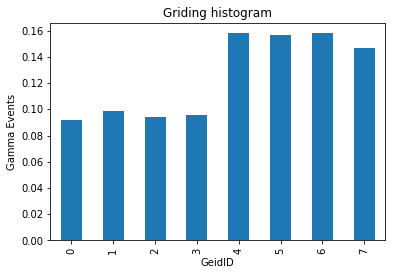

In [87]:
#===== 5 ===== Calculate IPD Method 2   WRONG******
#===========================================================================
# Count grid events and calculate P_i as Distri_P
#Show Griding results


print('Counting the real IPD by Method 2..............')
t5_2_1 = time.time()
#Counting
count_classes = pd.value_counts(df_test['GridID'], sort = True).sort_index()
count_classes = count_classes / Gamma_Num
# IPD
Real_Distri_P = np.zeros(shape = (Position_Nums),dtype = float)
Real_Distri_P[np.array(count_classes.index)] = GridID_Distri_P # p_i
t5_2_2 = time.time()
print("==================================================================")
print("---------------------------------5--------------------------------")
print("==================================================================")
print("Real_Distri_P.sum:",Real_Distri_P.sum(axis = 0))
print("IPD cell counts / Cells =",count_classes.shape[0],"/",Position_Nums)
print("Running Time:",t5_2_2 - t5_2_1,"s")

count_classes.plot(kind = 'bar')
plt.title("Griding histogram")
plt.xlabel("GeidID")
plt.ylabel("Gamma Events")
# plt.show()

0
1
2
3
4
5
6
7
8
9


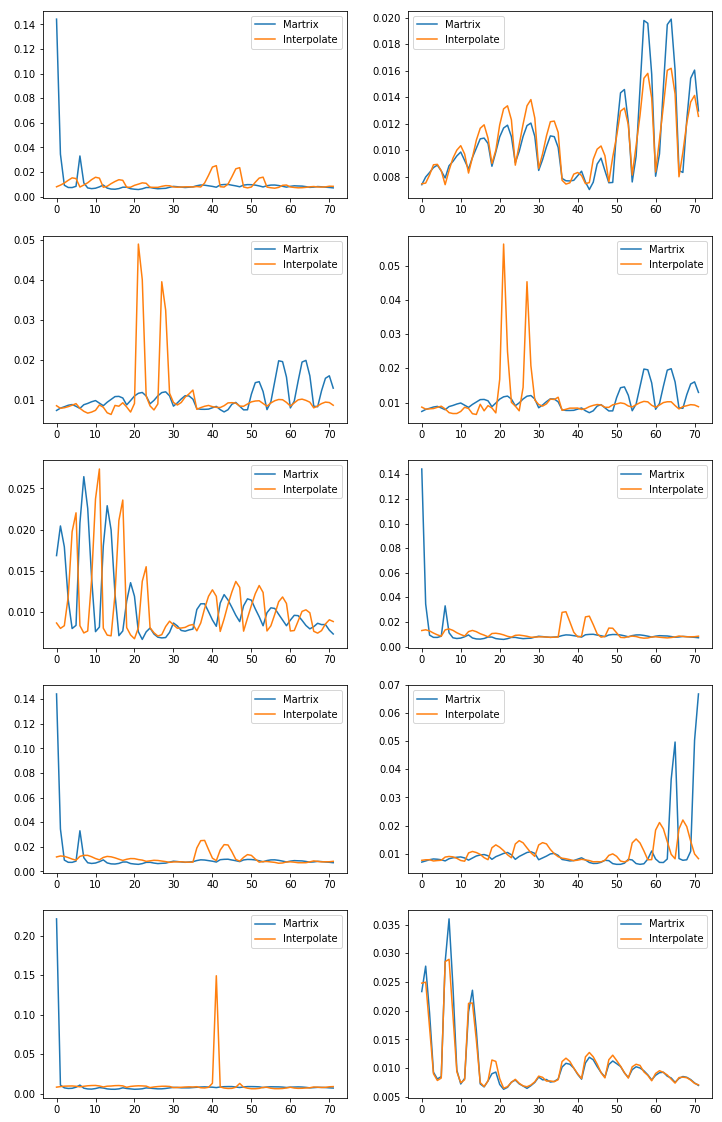

In [32]:
# Check Interpolating
array1 = np.array([-9.95,-9.5])
array2 = np.arange(-9,10,1)
array3 = np.array([9.5,9.95])
array_Sum = np.concatenate((array1,array2,array3),axis = 0)
x_p = array_Sum.copy()
y_p = array_Sum.copy()
z_p = array_Sum.copy()
points = np.array(np.meshgrid(x_p,y_p,z_p))
points.shape = 3,23*23*23
Coor_Cells_kis_interp = points.copy
points = points.T
data_Whole_Detector_kis = np.load('data/Results_Photon/data_Whole_Detector_kis.npy')
data_Whole_Detector_kis.shape = (23*23*23,6*6*2) # Only affect the order of the SIPM

Kis_1 = np.zeros(shape = (10,72),dtype = float)
Kis_2 = np.zeros(shape = (10,72),dtype = float)
plt.figure(figsize=(12,20))
for n in np.arange(10):
    x = df_test['x'][n]
    y = df_test['y'][n]
    z = df_test['z'][n]
    
    #==1
    L = 20 #mm                                            
    N_x = 200
    N_y = 200
    N_z = 200
    index_x = floor((N_x * x / L) + N_x / 2)  # i = x * N/L + N/2,  L = 20mm
    index_y = floor((N_y * x / L) + N_y / 2)  
    index_z = floor((N_z * x / L) + N_z / 2)
    Kis_1[n,:] = data_Whole_Detector_kis_Interp[index_z,index_y,index_x,:]
    
    #==2
    point_Gamma = np.array([x,y,z])
    for s in np.arange(6*6*2):
        values = data_Whole_Detector_kis[:,s]
        Kis_2[n,s] = griddata(points,values,point_Gamma,method = 'nearest')
    print(n)
    plt.subplot(5,2,n+1)
    plt.plot(np.arange(72),Kis_1[n,:],label = 'Martrix')
    plt.plot(np.arange(72),Kis_2[n,:],label = 'Interpolate')
    plt.legend(loc = 'best')
#     ax1.set_xlabel('SIPMID')
#     ax1.set_ylabel('Kis')
#     plt.title('Kis')
plt.savefig("picture/check_1.png")

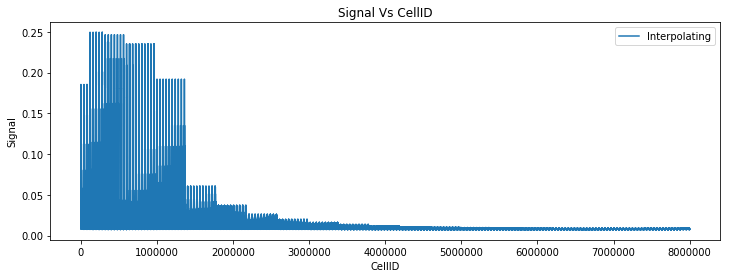

In [25]:
fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(np.arange(200*200*200), data_Whole_Detector_kis_Interp.reshape(200*200*200,72)[:,0],label = 'Interpolating')
plt.legend(loc = 'best')
ax2.set_xlabel('CellID')
ax2.set_ylabel('Signal')
plt.title('Signal Vs CellID')

plt.savefig("picture/check_2.png")

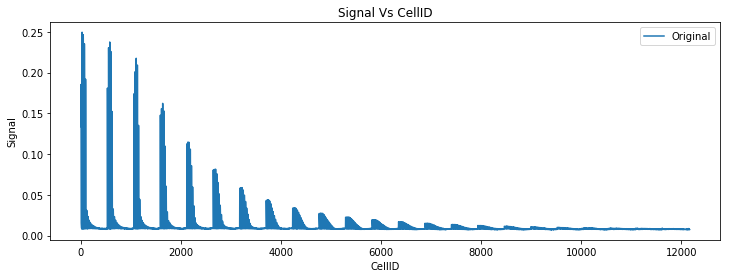

In [26]:
fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(np.arange(data_Whole_Detector_kis.shape[0]), data_Whole_Detector_kis[:,0],label = 'Original')
plt.legend(loc = 'best')
ax2.set_xlabel('CellID')
ax2.set_ylabel('Signal')
plt.title('Signal Vs CellID')

plt.savefig("picture/check_3.png")

In [270]:
data_Whole_Detector_kis_Interp.shape

(200, 200, 200, 72)

Text(0.5, 1.0, 'Signal')

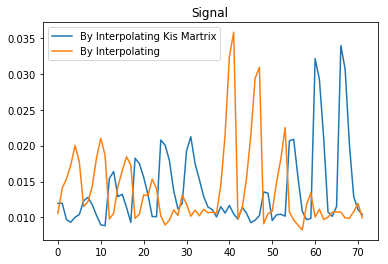

In [269]:
plt.plot(np.arange(72),df_test['SIPM_Signal1'][0],label = 'By Interpolating Kis Martrix')
plt.plot(np.arange(72),df_test['SIPM_Signal'][0],label = 'By Interpolating')
plt.legend(loc = 'best')
ax1.set_xlabel('SIPMID')
ax1.set_ylabel('Signal')
plt.title('Signal')

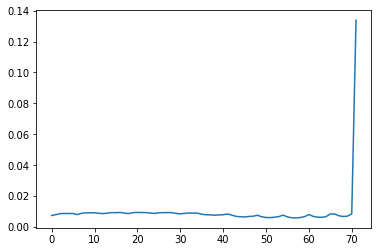

In [50]:
data_Whole_Detector_kis_Interp.shape
plt.plot(np.arange(72),data_Whole_Detector_kis_Interp[199,199,199,:])

Text(0, 0.5, 'a_is')

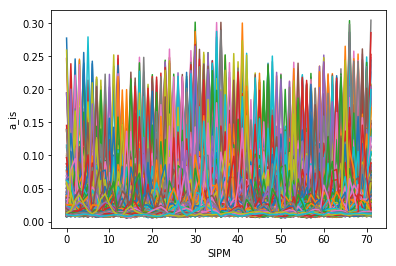

In [55]:
fig, ax = plt.subplots(figsize=(6,4))
for n in np.arange(DataSet_A.shape[0]):
    ax.plot(np.arange(72),DataSet_A[n,:])
ax.set_xlabel('SIPM')
ax.set_ylabel('a_is')


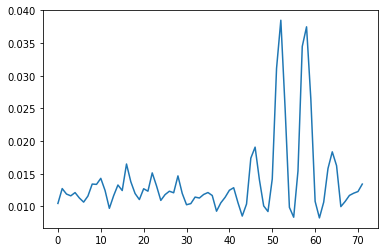

In [58]:
plt.plot(np.arange(72),DataSet_A[133,:])

In [5]:
df_test.iloc[:8]

,x,y,z,Edep
0,-7.86084,1.844020,7.28039,0.511
1,2.53285,0.615561,2.95402,0.511
2,3.49118,-7.480860,3.28973,0.511
3,3.04109,-7.029700,2.06908,0.511
4,-4.08897,-3.216470,8.62749,0.511
5,-7.74779,2.970800,-5.89749,0.511
6,-8.32235,3.183920,-2.58078,0.511
7,6.61927,1.831820,-3.75156,0.511


In [6]:
df_test.to_csv('data/Result_Gamma/Gamma_data.csv')

In [15]:
df_test1 = pd.read_csv('data/Result_Gamma/Gamma_data.csv')
df_test1.columns
df_test1.rename(columns = {'Unnamed: 0':'index'},inplace =True)
df_test1.set_index('index')

df_test1.iloc[:8]

,index,x,y,z,Edep
0,0,-7.86084,1.844020,7.28039,0.511
1,1,2.53285,0.615561,2.95402,0.511
2,2,3.49118,-7.480860,3.28973,0.511
3,3,3.04109,-7.029700,2.06908,0.511
4,4,-4.08897,-3.216470,8.62749,0.511
5,5,-7.74779,2.970800,-5.89749,0.511
6,6,-8.32235,3.183920,-2.58078,0.511
7,7,6.61927,1.831820,-3.75156,0.511
